## Assignment 3 Question 2

Is it possible to predict ELO of a player based on context of a potential en passant move?

Only investigating the player who is in the position of making the en passant move.

Lila See FDS PCA solutions for 3 good points for what PCA is good for - include in report?

#### Import Libraries

In [1]:
import pandas as pd
import chess
import chess.pgn
import chess.engine
import io
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
import importlib

from pandarallel import pandarallel

import data_cleaning

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### Import stockfish 🐟🐟🐟

In [2]:
# Windows installation
STOCKFISH_LOC = os.getcwd() + "\stockfish\stockfish-windows-2022-x86-64-avx2.exe"
# Unix based installation i.e. DICE/Codespaces
STOCKFISH_LOC_UNIX = os.getcwd() + "/stockfish_14_linux/stockfish_14_x64"

# Import stockfish package
from stockfish import Stockfish
# Try and read windows location
try:
    fish = Stockfish(path=STOCKFISH_LOC, depth=10, parameters={"Threads": 2, "Hash": 32})
    
# If error, read the linux location
except:
    fish = Stockfish(path=STOCKFISH_LOC_UNIX, depth=10, parameters={"Threads": 2, "Hash": 32})
    
# It will throw an error but if it still runs then ignore it :D

#### Import CSV file

66879 entries in dataframe

In [3]:
chess_data = data_cleaning.import_data()
print(chess_data.dtypes)

white_username    object
black_username    object
white_id          object
black_id          object
white_rating       int64
black_rating       int64
white_result      object
black_result      object
time_class        object
time_control      object
rules             object
rated               bool
fen               object
pgn               object
dtype: object


#### Dataframe info

Using:
print(chess_data.dtypes)
print(chess["rules"].unique())


Chess rules:
['chess' 'chess960' 'threecheck' 'crazyhouse' 'kingofthehill']

Time control:
['1/259200' '1/172800' '1800' '1/86400' '1/432000' '1/604800' '600'
 '120+1' '900+10' '300' '180+2' '3600+5' '2700+45' '3600' '1/1209600'
 '180' '600+10' '60' '480+3' '300+5' '420+3' '600+5' '600+2' '1200' '30'
 '60+1' '120' '1500+3' '900+2' '1500+5' '1500+10' '1/864000' '900' '300+2'
 '1500' '7200' '300+1' '5400' '3600+60' '2700+30' '3480+45' '10' '2700+10'
 '15' '2700' '3600+20' '4500' '4200' '900+5' '1800+10' '2700+5' '480+5'
 '1800+30' '300+3' '600+1' '1800+5' '420+5' '5400+30' '240+10' '420' '303'
 '60+10']

 Time class:
['daily' 'rapid' 'bullet' 'blitz']

#### Clean data

Undeveloped board shouldn't matter if we're filtering games for potential ep

Same for draws

Can filter our time class if are looking at time controls

After making a new move_list column, should we drop the pgn column?


Variables we are considering when predicting ELO (for a player who could potentially make en passant move) are:
- Colour who had ep opportunity (boolean)
- Did they take the en passant? (boolean)
- Does their choice on taking/not taking support them if gaining an advantage? (numerical value for how much of an advantage it gives) [Lila rn is __________________]
- 
- Time taken to decide to capture/not capture en passant (percentage of total time for the game)
- Is the game rated? (boolean)
- Game time class (numerical value), don't include daily because daily don't have times attached to move

In [4]:
# Save PGN column from dataframe
full_pgn = chess_data['pgn']

def get_moves(entry):
    '''
    Retrive series of moves in a game when given the whole full_pgn entry.
    '''
    pgn = entry.splitlines()[-1]
    return pgn

# Add list of moves (string) as a new column to dataframe
chess_data['move_list'] = full_pgn.apply(get_moves)

# Drop irrelevant columns
chess_data = chess_data.drop(['white_username', 'black_username','white_id', 'black_id', 'white_result', 'black_result', 'rules'], axis=1)

### Processing data and adding information

#### Checks every game for ones that have potential en-passant moves
- Gets whether a game has an en-passant opportunity
- Gets whether the said en passant move was played
- Gets the colour of the player that has the e.p. opportunity

In [5]:
def check_pgn(df_row):
    import io
    import chess
    import chess.pgn
    
    '''
    Checks PGN for whether opportunity for EP happened in the game.
    '''
    
    pgn_file = io.StringIO(df_row["pgn"])   # PGN as a file
    game = chess.pgn.read_game(pgn_file)    # Read PGN and put into game
    board = game.board()                    # "board" of a game
    # pre-initialise df_row values
    precheck = False
    moved = False
    move_colour = ""

    # comparison sets when checking move piece
    ep_set = set(["ax","bx","cx","dx","ex","fx","gx", "hx"])
    check_set = set("abcdefgh")
    
    # Find only pawn moves in game
    for board_move in game.mainline():
        move = board_move.move
        san = board.san(move)
        turn = board.turn
        move_piece = san[0]
        # check if precheck was flagged in previous move
        if precheck:
            # print(board_move.clock())
            # get first 2 letters, and compare to a set
            move_ep_piece = san[:2]
            if move_ep_piece in ep_set:
                # check if e.p. actually happened
                moved = board.is_en_passant(move)
            # break out for loop, no need to check further
            break
        
        # if the move was a pawn (lower case)
        if move_piece in check_set:
            # Push the move before checking the board
            board.push(move)
            # check if the next move can be en passant
            precheck = board.has_legal_en_passant()
            # if precheck is true then set the turn
            if precheck:
                if turn:
                    move_colour = 'Black'
                else:
                    move_colour = 'White'
        # if the move wasn't a pawn then just continue as normal
        else:
            board.push(move)
    
    # set row values
    df_row["ep_opportunity"] = precheck
    df_row["ep_happened"] = moved
    df_row["ep_colour"] = move_colour
    return df_row

chess_filter = chess_data.copy(deep=True)
# chess_filter = chess_data[chess_data["time_class"] != "daily"].sample(100).copy(deep=True)
pandarallel.initialize()

start = time.time()
# apply e.p. finding function
try:
    chess_filter = chess_filter.parallel_apply(check_pgn, axis=1)
except:
    chess_filter = chess_filter.apply(check_pgn, axis=1)
end = time.time()
print(end - start)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/
121.89781332015991


#### Filter out games that don't have en-passant opportunity

In [6]:
chess_filter = chess_filter[chess_filter['ep_opportunity'] == True]
chess_filter = chess_filter.drop(['ep_opportunity'], axis=1)
chess_filter = chess_filter.reset_index(drop=True)
print(len(chess_filter))
print(len(chess_filter[chess_filter['ep_happened'] == True]))
# print(chess_filter["move_list"].sample(50).head(20))

5074
1563


#### Get the time taken to respond to an en-passant pawn move

In [7]:

def check_times(df_row):
    import io
    import chess
    import chess.pgn
    
    '''
    Checks PGN for whether opportunity for EP happened in the game.
    '''
    # print(df_row["move_list"])
    pgn_file = io.StringIO(df_row["pgn"])   # PGN as a file
    game = chess.pgn.read_game(pgn_file)    # Read PGN and put into game
    board = game.board()                    # "board" of a game
    # pre-initialise df_row values
    precheck = False

    # comparison sets when checking move piece
    check_set = set("abcdefgh")
    
    rolling_white_time = [0,0]
    rolling_black_time = [0,0]
    
    # Find only pawn moves in game
    for board_move in game.mainline():
        # print(board_move.clock())
        if board.turn:
            rolling_white_time = [board_move.clock(), rolling_white_time[0]]
            # print(rolling_white_time)
        else:
            rolling_black_time = [board_move.clock(), rolling_black_time[0]]
            # print(rolling_black_time)
        
        move = board_move.move
        san = board.san(move)
        move_piece = san[0]
        # check if precheck was flagged in previous move
        if precheck:
            # print(board_move.clock())
            # get first 2 letters, and compare to a set
            norm = df_row["time_control"]

            if board.turn:
                df_row["time_taken"] = (rolling_white_time[1] - rolling_white_time[0])/float(norm)
            else:
                df_row["time_taken"] = (rolling_black_time[1] - rolling_black_time[0])/float(norm)
            # print(df_row)
            return df_row
        
        # if the move was a pawn (lower case)
        # print(move_piece)
        if move_piece in check_set:
            # Push the move before checking the board
            board.push(move)
            # check if the next move can be en passant
            precheck = board.has_legal_en_passant()
            # print(precheck)
            # if precheck is true then set the turn
        # if the move wasn't a pawn then just continue as normal
        else:
            board.push(move)
    return df_row

pandarallel.initialize()

start = time.time()
# apply e.p. finding function
try:
    chess_filter = chess_filter.parallel_apply(check_times, axis=1)
except:
    chess_filter = chess_filter.apply(check_times, axis=1)
end = time.time()
print(end - start)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/
9.582859754562378


#### Stockfish Evaluation to get evaluations of board choices
- Gets the evaluation before an ep opportunity
- Gets the evaluation of the best move calculated by Stockfish
- Gets the evaluation of the (best) en passant move calculated by Stockfish

In [8]:
import stockfish_eval
importlib.reload(stockfish_eval);

def stockfish_analyse_board(df_row, board, move):
    '''
    Gets a stockfish evaluation of the best move played,
    and also the evaluation if e.p. is played.
    Returns a triple of pre-move evaluation, evaluation difference of best
    move, evaluation difference of (best) en passant move.
    '''
    fish_eval = stockfish_eval.StockfishEval(fish, board, df_row["ep_colour"])

    # reset fen
    fish_eval.reset_fen()
    
    fish_eval.set_player_move(move)
    # get pre-move evaluation
    pre_eval = fish_eval.evaluate_board()["value"]

    player_move_is_ep = fish_eval.check_move_is_ep(move)
    
    # if player_move_is_ep:
    fish_eval.get_best_move()
    # else:
    fish_eval.find_adj_squares()
    fish_eval.find_bounds()
    fish_eval.find_valid_pawns()
    fish_eval.find_ep_moves()
        
        
    # should end up with either
    
    # self.move_list = {
    #             "best_move": "move",
    #             "player_move": "",
    #             "ep_move_left": "maybe a move",
    #             "ep_move_right": "maybe a move"
    #         }
    
    # or
    
    # self.move_list = {
    #             "best_move": "",
    #             "player_move": "move",
    #             "ep_move_left": "maybe a move",
    #             "ep_move_right": "maybe a move"
    #         }
    
    # if the user played EP, then get eval of the users board
    # and get the eval of what the best move would have been
    # if player_move_is_ep:
    
    # player_eval = fish_eval.evaluate_player_move()
    # player_difference = fish_eval.get_abs_advantage(player_eval, pre_eval)
    
    # if fish_eval.get_movelist()["best_move"] == move:
    #     best_eval = player_eval
    #     best_difference = player_difference
    # else:
    #     best_eval = fish_eval.evaluate_best_move()
    #     best_difference = fish_eval.get_abs_advantage(best_eval, pre_eval)
        
    # if move == fish_eval.get_movelist()["ep_move_left"] or move == fish_eval.get_movelist()["ep_move_right"]:
    #     ep_eval = player_eval
    #     ep_difference = player_difference
    # else:
    #     ep_eval = fish_eval.evaluate_en_passants()
    #     ep_difference = fish_eval.get_abs_advantage(best_eval, pre_eval)
    moveList = fish_eval.get_movelist()
    best_eval = fish_eval.evaluate_best_move()
    best_difference = fish_eval.get_abs_advantage(best_eval, pre_eval)
    if moveList["best_move"] == moveList["ep_move_left"] or moveList["best_move"] == moveList["ep_move_right"]:
        ep_eval = best_eval
        ep_difference = best_difference
    else:
        ep_eval = fish_eval.evaluate_en_passants()
        ep_difference = fish_eval.get_abs_advantage(ep_eval, pre_eval)
    return [pre_eval, best_difference, ep_difference]

def get_advantage(df_row):
    '''
    Get stockfish evaluations for a given game
    Sets columns "pre_state", "state_best", "state_ep" for a df row
    '''
    # pawn lookup set
    check_set = set("abcdefgh")
    # print(df_row.name)
    
    # initialise board
    pgn_file = io.StringIO(df_row["pgn"])   # PGN as a file
    game = chess.pgn.read_game(pgn_file)    # Read PGN and put into game
    board = game.board()                    # "board" of a game

    # e.p. check
    precheck = False
    
    # initialise vars
    pre_eval = 0
    post_eval_best_diff = 0
    post_eval_ep_diff = 0
    
    # iterate over every move in a game
    for move in game.mainline_moves():
        # representation of a move
        san = board.san(move)
        move_piece = san[0]

        # check if precheck was flagged in previous move
        if precheck:
            # reset to not flag final move precheck edge case 
            precheck = False

            # analyse board
            values = stockfish_analyse_board(df_row, board, str(move))
            # print(values)
            # set values
            pre_eval = values[0]
            best_eval = values[1]
            ep_eval = values[2]
            # break out of for loop since we have all values
            break
            
            
        # if the move was a pawn (lower case)
        if move_piece in check_set:
            # Push the move before checking the board
            board.push(move)
            # check if the next move can be en passant
            precheck = board.has_legal_en_passant()
        # if the move wasn't a pawn then just continue as normal
        else:
            board.push(move)

    # edge case where the final move was pawn 2 space, and there is no next
    # move to run stockfish_analyse_board
    if precheck:
        # checkstr = df_row["pgn"]
        # if re.search("won\sby\s(time|resignation|abandoned)\"\]", checkstr) != None:
        #     df_row["pre_state"] = pd.NA     # pre-moved stockfish eval
        #     df_row["state_best"] = pd.NA  # stockfish eval if best move
        #     return df_row
        # # colour is the colour of the player with the opportunity
        # values = stockfish_analyse_board(df_row, board, san)
        # # set values
        pre_eval = pd.NA
        best_eval = pd.NA
        ep_eval = pd.NA
    
    # set dataframe values
    df_row["pre_state"] = pre_eval     # pre-moved stockfish eval
    df_row["state_best"] = best_eval  # stockfish eval if best move
    df_row["state_ep"] = ep_eval
    # print(df_row["pgn"])
    return df_row

# get_advantage(chess_filter.iloc[486])
chess_filter = chess_filter.apply(get_advantage, axis=1)

In [9]:
# print(len(chess_filter[(chess_filter["state_best"] == chess_filter["state_ep"]) & (chess_filter["ep_happened"] == True)]))
nn = 5
print(chess_filter.head(10))
# raise Exception("stop")

   black_rating ep_colour  ep_happened  \
0          1540     White        False   
1          1485     Black         True   
2          1177     Black        False   
3          1531     Black         True   
4          1523     Black         True   
5          1150     Black        False   
6          1564     Black         True   
7          1266     White         True   
8          1560     Black         True   
9          1596     Black        False   

                                                 fen  \
0  r4k2/1p3r2/p2p2n1/2pPp3/2P1P1b1/1P2b1P1/P3NR1P...   
1                 8/1p5k/P2q4/7P/1P6/8/7K/r4q2 w - -   
2  3r1r2/6k1/pp4pp/2pBPp2/2P3q1/P2PQ1P1/1P3R1P/R5...   
3  r5k1/pp4pp/3b2r1/3p1p2/1P1P4/P3PpP1/2RBq2P/R3K...   
4  4Q1k1/3p1p1p/5bpB/1p6/2q5/P1Pp2P1/1P3PKP/RN6 b...   
5         7k/2P5/4Q1pp/8/3N4/1N4PP/P1q2P2/R5K1 b - -   
6                     7k/8/7p/p1Kp4/8/1b5P/8/8 w - -   
7       5rrk/pp4p1/2p3Qp/8/3PB3/2q2PR1/P4PKP/8 b - -   
8            5r2/5pk1/p7/1p4Q1/8/

### Applying PCA


In [10]:
def group_elo(df_row):
    col = df_row["ep_colour"]
    if col == "White":
        elo = df_row["white_rating"]
    else:
        elo = df_row["black_rating"]
    
    # if elo <= 500:
    #     df_row["elo_class"] = 1
    if elo <= 1000:
        df_row["elo_class"] = 1
    # elif elo <= 1500:
    #     df_row["elo_class"] = 3
    elif elo <= 2000:
        df_row["elo_class"] = 2
    # elif elo <= 2500:
    #     df_row["elo_class"] = 5
    else:
        df_row["elo_class"] = 3
    return df_row

def temptation(df_row):
    if (df_row["state_best"] == 0):
        df_row["temptation"] = pd.NA
    else:
        df_row["temptation"] = df_row["state_ep"] / df_row["state_best"]
    return df_row
# chess_filter = chess_filter2
chess_filter = chess_filter.dropna()
chess_filter = chess_filter.apply(group_elo, axis=1)
chess_filter = chess_filter.apply(temptation, axis=1)

# Replace Boolean and string variables with numbers
chess_filter['ep_happened'] = chess_filter['ep_happened'].replace({True:1, False:0})
chess_filter['ep_colour'] = chess_filter['ep_colour'].replace({'White':1, 'Black':0})
chess_filter['rated'] = chess_filter['rated'].replace({True:1, False:0})
chess_filter['time_class'] = chess_filter['time_class'].replace({'rapid':2, 'blitz':1, 'bullet':0})

# Drop irrelevant columns, and save differently - as a dataframe including the rating and one without
chess_data_with_elo = chess_filter.drop(['fen', 'pgn', 'move_list', 'rated', 'time_control'], axis=1)

# chess_data_with_elo["eval_diff"] = chess_data_with_elo["state_ep"] - chess_data_with_elo["state_best"]
# chess_data_with_elo["eval_diff"] = chess_data_with_elo["state_best"]
# chess_data_with_elo = chess_data_with_elo.drop(['state_best', 'state_ep'], axis=1)

# chess_data_with_elo["diff_with_best"] = chess_data_with_elo["state_best"]
# chess_data_with_elo["diff_with_ep"] = chess_data_with_elo["state_ep"]

chess_data_with_elo = chess_data_with_elo.drop(['state_best', 'state_ep', 'pre_state', 'white_rating', 'black_rating'], axis=1)

chess_data_with_elo = chess_data_with_elo.dropna()

print(chess_data_with_elo.head())
print('\n')


# print(len(chess_data_with_elo[chess_data_with_elo["eval_diff"] < 0]))

   ep_colour  ep_happened  time_class  time_taken  elo_class temptation
0          1            0           2    0.013667          2  -2.666667
1          0            1           2    0.003333          2    -3917.0
2          0            0           0    0.052500          2  11.818182
3          0            1           2    0.003667          2        1.0
4          0            1           2    0.011333          2        1.0




##### Data Standardisation (For PCA)

Cite week 8 lab sheet in report? Heavily used their code to help

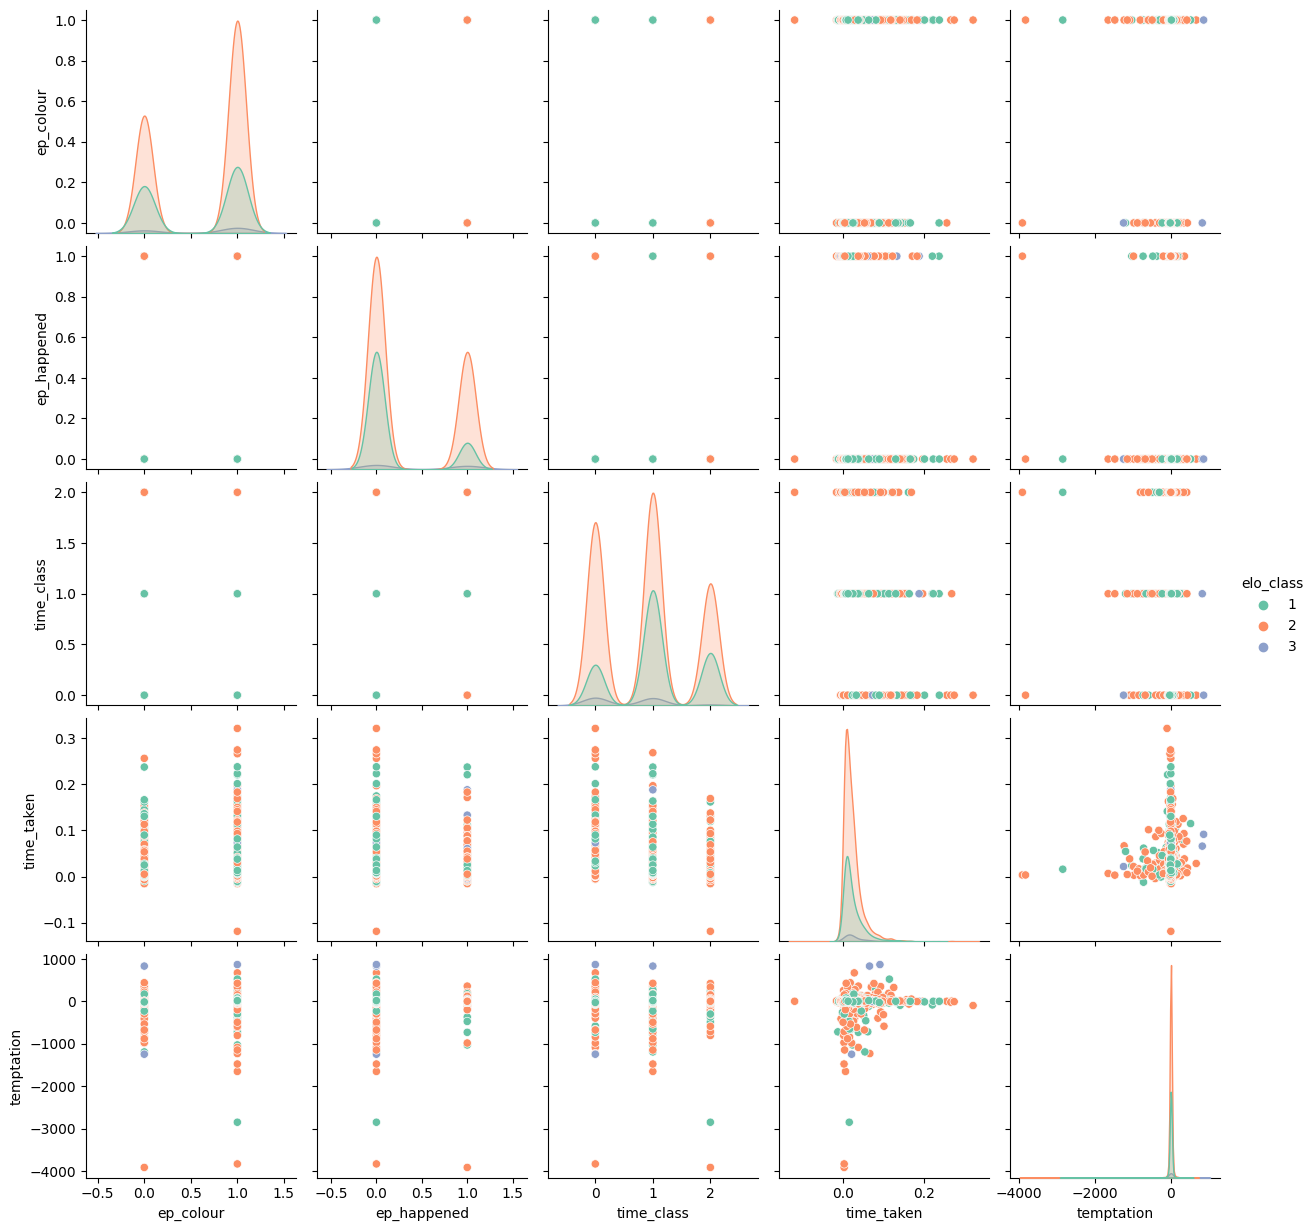

In [11]:
def standardize(df):
    standardized = pd.DataFrame()
    for col in df.columns: # We can apply mathematical operation to entire columns at once, as they are built on top of numpy arrays
        standardized[col] = (df[col]-df[col].mean())/df[col].std() #For each column move the data s.t. it is centered around 0 and has variance=1
    return standardized


sns.pairplot(hue='elo_class', data=chess_data_with_elo, palette="Set2")

# # Lila Can we instead use this? :
# standardise = stan
# pca = PCA(n_components=5).fit(chess_data_without_elo.values)
# pca_result = pca.transform(chess_data_without_elo.values)
# sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=)
# plt.xlabel('PC1')
# plt.ylabel('PC2')

[0.25049328 0.21036987 0.19956976 0.1976647  0.14190239]
0.5835866261398176


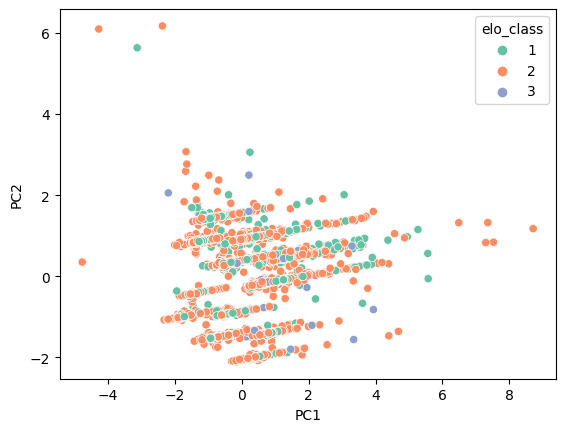

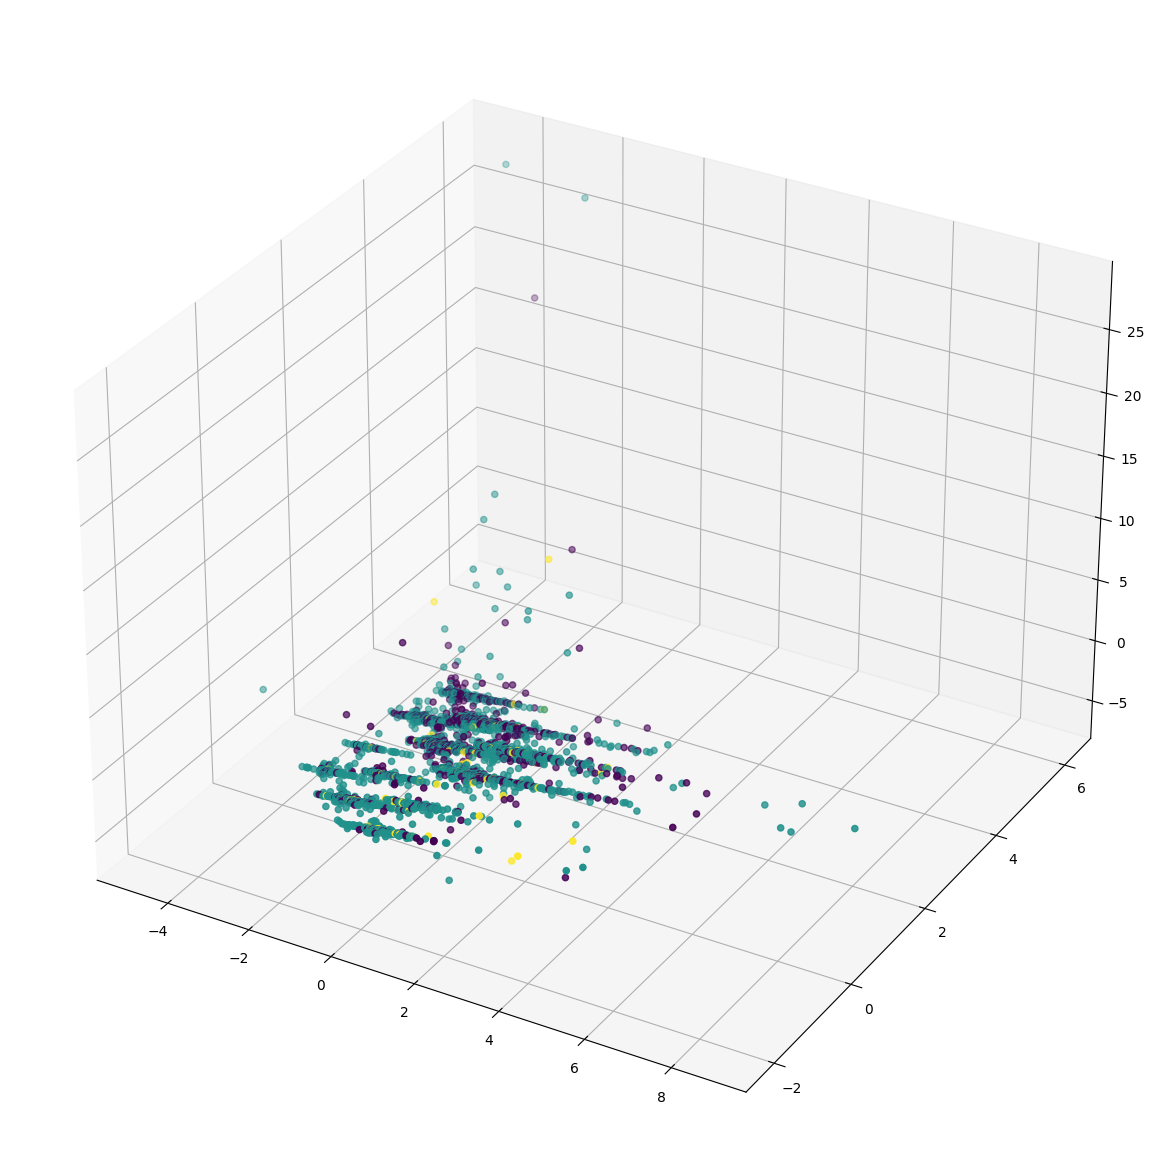

In [12]:
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
elo_labels=chess_data_with_elo["elo_class"]
elo_features=chess_data_with_elo.drop(columns=["elo_class"])

train, test, train_lbl, test_lbl = train_test_split(elo_features, elo_labels, test_size=0.2)

scaler = StandardScaler()
scaler.fit(train)

# Apply transform to both the training set and the test set
# train = standardize(train)
# test = standardize(test)
train = scaler.transform(train)
test = scaler.transform(test)
# Make an instance of the pca model
pca = PCA(n_components=5)
pca.fit(train)
print(pca.explained_variance_ratio_)

# Transform images with pca model
train_result = pca.transform(train)
test_result = pca.transform(test)
# print(train_result)
# Make an instance of knn model
knn = KNeighborsClassifier(6)
knn.fit(train_result, train_lbl)

# Accuracy of knn test
accuracy = knn.score(test, test_lbl)
print(accuracy)

sns.scatterplot(x=train_result[:, 0], y=train_result[:, 1], hue=train_lbl, palette="Set2")
plt.xlabel('PC1')
plt.ylabel('PC2')


fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_result[:, 0], train_result[:, 1], train_result[:, 2], c=train_lbl)

# test.drop("time_class")
# print(train.dtypes)
# print()
# print(test.dtypes)

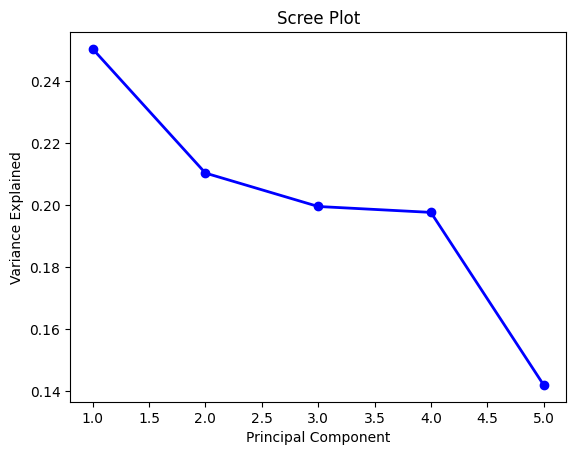

In [13]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

### Making Scree plot for K-Means, Elbow Method

Plotting mean squared error E against number of clusters K

c:\Users\lilam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\lilam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\lilam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\lilam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

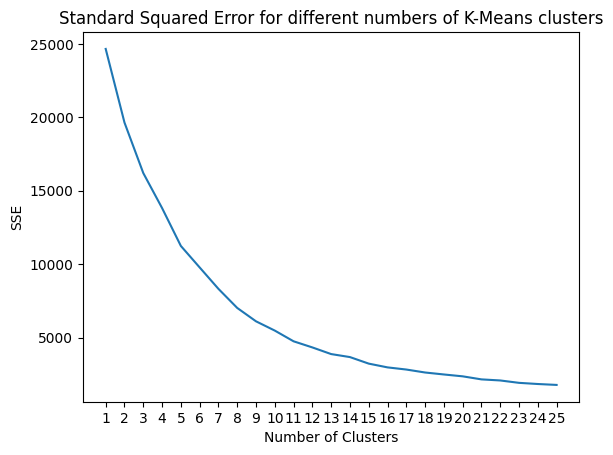

In [68]:
upper = 26

elo_labels = chess_data_with_elo["elo_class"]
elo_features = chess_data_with_elo.drop(columns=["elo_class"])

# Standardize ELO features
scaler = StandardScaler()
scaled_elo_feats = scaler.fit_transform(elo_features)

# Find standard squared error for each k
SSE = []
for k in range(1, upper):
    pre_k_means = KMeans(n_clusters=k)
    pre_k_means.fit(scaled_elo_feats)
    # Record SSE for this k
    SSE.append(pre_k_means.inertia_)

# Create Scree plot
plt.title("Standard Squared Error for different numbers of K-Means clusters")
plt.plot(range(1, upper), SSE)
plt.xticks(range(1, upper))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### Applying K-Means

c:\Users\lilam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


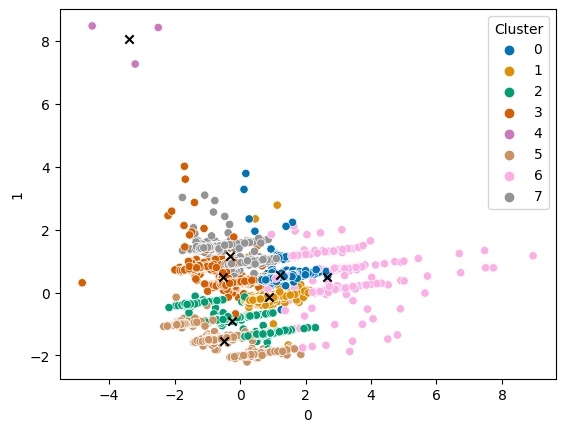

In [72]:
# Instantiate K-Means model
num_clusters = 8
num_PCA_components = 5

# Apply PCA to reduce number of dimensions
pca = PCA(n_components=num_PCA_components).fit(scaled_elo_feats)
pca_scores = pca.transform(scaled_elo_feats)

# Apply K-Means clustering
model_kmeans = KMeans(n_clusters=num_clusters, max_iter=10) # Lila Justify why max_iter=5
pca_scores_kmeans = model_kmeans.fit(pca_scores)

# Find cluster centres
centres = np.array(model_kmeans.cluster_centers_)

# Initialise new dataframe for K-Means predictions
kmeans_df = pd.DataFrame(pca_scores)
predicted = []

# Fit model to each PCA score
for s in pca_scores:
    predicted.append(model_kmeans.predict(s.reshape(1, -1)))

# Helper method to convert 'predicts's list format into a single element
def list_to_elem(lst):
    '''Converts single element list to an element'''
    return lst[0]

# Add predicted points to dataframe
kmeans_df['Cluster'] = predicted
kmeans_df['Cluster'] = kmeans_df['Cluster'].apply(list_to_elem)

# Plot scatter plot
sns.color_palette("colorblind")

sns.scatterplot(x=kmeans_df.iloc[:,0],
                y=kmeans_df.iloc[:,1],
                hue=kmeans_df['Cluster'],
                palette='colorblind')

plt.scatter(centres[:,0], centres[:,1], marker="x", color='black')


In [24]:
# calculate min, max and limits
h = .02

x_min, x_max = train_result[:, 0].min() - 1, train_result[:, 0].max() + 1
y_min, y_max = train_result[:, 1].min() - 1, train_result[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
np.arange(y_min, y_max, h))

# predict class using data and kNN classifier
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(train_result[:, 0], train_result[:, 1], c=y, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i)" % (n_neighbors))
plt.show()


ValueError: X has 2 features, but KNeighborsClassifier is expecting 5 features as input.